# TL;DR

In this blog post, a Dirichlet filter is described, which can be used to effectively track the class of an object over time.
It is described how to get the best estimate, the uncertainty about the best estimate as well as some simulation experiments to show the behaviour of the filter.

# Table of content

* [Introduction](#intro)
* [Dirichlet Filter](#dirichlet-filter)
    * [Dirichlet Distribution](#dirichlet-distribution)
    * [Implementation](#dirichlet-implementation)
        * [State Estimation](#dirichlet-state_estimation)
        * [Update](#dirichlet-update)
        * [Predict](#dirichlet-prediction)
* [Simulationed Experiments](#simulation)
    * [Measurement Generation](#measurement-gen)
    * [Single Track](#single-track)
    * [Prediction Behaviour](#prediction-behaviour)
* [Fusion](#fusion)
* [Merge](#merge)
* [Use of uncertainty](#uncertainty)
* [Normalization](#normalization)

# Intro <a class="anchor" id="intro"></a>

In my experience, when it comes to classification, much attention is given to the classification algorithm (e.g. tuning the classifier to be as best as it can get) and less is given to the filtering aspect.
Of course filtering is only possible if you have either multiple classification algorithms running at the same time or a time series, like a video stream.
In such case, you can gather information along the time series and gain knowledge about the uncertainty of the current class estimation. 

If that is something of interest to you, you might want to have a look at the Dirichlet Filter, which is described in the following.

# Dirichlet Filter <a class="anchor" id="dirichlet-filter"></a>

The basic idea is that we view the class of our object of interest as a probability mass function (pmf) over all possible classes instead of a single class.
Having this, the Dirichlet distribution is a probability distribution over such pmf's, which makes it the perfect canditate for our purpose.

Using the Dirichlet distribution, we 
* need no prior knowledge about the classifier
* gain an estimate about the certainty

But first things first: What is a Dirichlet distribution?

## Dirichlet Disitrbution <a class="anchor" id="dirichlet-distribution"></a>

A Dirichlet distribution is a distribution over distributions....sounds a bit complex but it's not that bad.
The Dirichlet distribution has a parameter vector (here named $\alpha$), where each element $\alpha_i$ is a counter of class $i$ on how often this class has been observed (or measured).

From that it calculates the likelihood of each possible pmf (e.g. that the classifier "samples" from this pmf: Class1: 80%, Class2: 5%, Class3: 15% or short [80%,5%,15%]), which could have generated the observed $\alpha$. 

Mathematically the PDF of Dirichlet distribution is modeled as the following:
$
    Dir(\theta|\alpha)=\frac{1}{B(\alpha)} \prod_{i=1}^{K} \theta_i^{\alpha_i-1}\\
    B(\alpha) = \frac{\prod_{i=1}^K \Gamma(\alpha_i)}{\Gamma(\sum_{i=1}^K(\alpha_i))}\\
    \Gamma(x) = \text{Generalization of the factorial function}\\
    K = \text{Number of classes}\\
    \theta = \text{A possible pmf}
$

Below you find illustrations of a Dirichlet distribution with three possible classes. In the corners of the triangle are the extrem pmfs [100%,0,0], [,0,100%,0] and [0,0,100%] at the center of the triangle is the uniform distribution [33.33%,33.33%,33.33%]. The colors depite the certainty of the pmf estimation. A wider shape implies more uncertainty.

Take some time to make you familiar with these plots, as these are quite important to understand in the following.

In [1]:

from IPython.display import HTML
from IPython.display import Code

import sys
import math
import random
import inspect

import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.tri as tri
from matplotlib import gridspec
from matplotlib.patches import Ellipse

import numpy as np
np.random.seed(42)


from scipy.stats import beta, dirichlet

# Own code
sys.path.insert(0, './') # add local sources
from internal.DirichletFilter import DirichletFilter
from internal.ClassifierSimulator import ClassifierSimulator

# More than 3 breaks the plots as they would get multi-dimensional. Nevertheless, mathematically the number of classes is unlimited
num_classes = 3

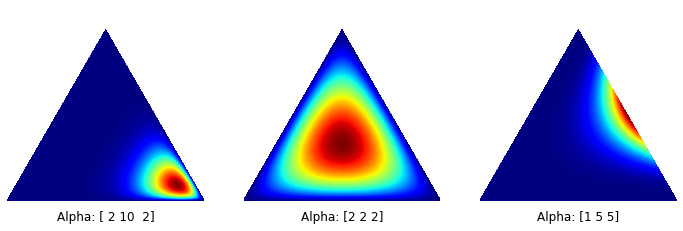

In [2]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))


def xy2bc(xy, tol=1.0e-4):
    """Converts 2D Cartesian coordinates to barycentric."""
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)


class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul

        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / np.multiply.reduce(
            [gamma(a) for a in self._alpha]
        )

    def pdf(self, x):
        """Returns pdf value for `x`."""
        from operator import mul

        return self._coef * np.multiply.reduce(
            [xx ** (aa - 1) for (xx, aa) in zip(x, self._alpha)]
        )


def draw_pdf_contours(ax, dist, nlevels=200, subdiv=6, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    ax.clear()
    ax.tricontourf(trimesh, pvals, nlevels, cmap="jet", **kwargs)
    ax.axis("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.75**0.5)
    ax.axis("off")
    ax.set_title("Alpha: " + str(dist._alpha), y=-0.01)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

draw_pdf_contours(ax1, Dirichlet([2, 10, 2]))
draw_pdf_contours(ax2, Dirichlet([2, 2, 2]))
draw_pdf_contours(ax3, Dirichlet([1, 5, 5]))

These plots are depicting a Dirichlet distribution with three classes. Below the plot is the alpha parameter.

## Dirichlet Filter Implementation <a class="anchor" id="dirichlet-implementation"></a>

The implementation of such filter is rather simple. You can find a complete implementation in the python file in the internals folder.
Nevertheless, here it is described in detail, which makes it easier to understand whats going on.

In terms of memory, the filter needs to hold two vectors:
* alpha, which is representing the $\alpha$ parameter 
* state, which is the current estimation of the distribution (optional as it can be calculated on the fly)

In general the number of classes should be known before. I guess there is a quite easy way around it, but for now lets assume that the number of possible classes is known.
In some applications, the time between two classifcations (also called measurements here) is not constant, which is why it is usefull to have the average time between two measurements in order to compensate for this later. The basic assumption is that the class could change over time. Missing classifications over a longer period of time increases the chances of the object to have changed.

In [3]:
lines = "class " + DirichletFilter.__name__ + "\n"
lines += inspect.getsource(DirichletFilter.__init__)
Code(lines, language="python")

class DirichletFilter
    def __init__(self, num_classes=3, measurement_period=0.05):
        self.num_classes = num_classes
        self.measurement_period = measurement_period  # average time between two measurements
        self.decay_factor = 0.95  # how much does the dirichlet distribution forget over time
        self.state = np.ones(num_classes) / num_classes  # uniform distribution as prior
        self.alpha = np.ones(num_classes)  # count values of the Dirichlet distribution

### State estimation  <a class="anchor" id="dirichlet-state_estimation"></a>

For the state estimation, we can choose different points within the Dirichlet distribution.
For this we can use for example the 
* mean $\hat{\theta}_j = \frac{\alpha_j}{\sum(\alpha_j)}$
* mode $\hat{\theta}_j = \frac{\alpha_j-1}{\sum(\alpha_j-1)}$

of the Dirichlet distribution.



<div class="alert alert-block alert-info"><b>Decision:</b> 
    Here I am going with the <b>mean</b>, as it provides a pmf, where every class has a probability $>0$.
    
This is mandatory, if this state is used in the future in the measurement assignment. But choose it according to your specific application
</div>


Example from multiple object tracking:

A measurement classified as car might be still assigned with an object which was only clasified as a truck. (Otherwise the first classification will determine the class of the object immediately.)

In [4]:
lines = "class DirichletFilter\n"
lines += "    ...\n\n"
lines +=inspect.getsource(DirichletFilter.estimate_state)
lines += "\n"
lines +=inspect.getsource(DirichletFilter.estimate_state_using_mode)
lines += "\n"
lines +=inspect.getsource(DirichletFilter.estimate_state_using_mean) 
lines += "\n"
Code(lines, language="python")

class DirichletFilter
    ...

    def estimate_state(self):
        self.estimate_state_using_mean()

    def estimate_state_using_mode(self):
        self.state = (self.alpha - 1) / (np.sum(self.alpha) - self.num_classes)

    def estimate_state_using_mean(self):
        self.state = self.alpha / np.sum(self.alpha)

### Update <a class="anchor" id="dirichlet-update"></a>
The update of the Dirichlet Filter is straight forward as is simply adds the current measurement to the $\alpha$ parameter.
More mathematically correct speaking:

$
\begin{align}
P(\theta|X) &\propto P(X|\theta)P(\theta)\\
            &\propto \left( \prod_{i=1}^K \theta_i^{z_j}\right) \left( \prod_{i=1}^K \theta_i^{\alpha_i-1}\right)\\
            &= \prod_{i=1}^K \theta_i^{z_j+\alpha_i-1} \\
P(\theta|X) &= Dir(z+\alpha)
\end{align}
$

Hence the update boils down to a simple addition:

<div class="alert alert-block alert-info"><b>Update equation:</b>

$\alpha = \alpha + z$
</div>


After updating the $\alpha$ parameter, we also need to update our point estimate (aka. state)

In [5]:
lines = "class DirichletFilter\n"
lines += "    ...\n\n"
lines += inspect.getsource(DirichletFilter.update)
Code(lines, language="python")

class DirichletFilter
    ...

    def update(self, measurement):
        self.alpha += measurement
        self.estimate_state()

### Prediction <a class="anchor" id="dirichlet-prediction"></a>

There is no defined prediction (at least I could not find any). Hence we need to come up with our own.

>But first: **Why do we want to predict the class?**
> * control the adaption of changing ground truth class
> * Limit $\alpha$ as it is otherwise an unbound sum

One way of modeling this is to slowly forget overtime what we have observed. Hence a decay factor $f = \{f \in \mathbb{R}| 0 < f < 1\}$ is introduced.

If we want to forget $10\%$ of our knowledge with every prediction, the decay factor would be $f = 1-0.1 = 0.9$.
Now we can simply multiply $\alpha$ with the decay factor and have a simple prediction.

This limits the max values of each $\alpha_i$ by $\frac{1}{1-f}$ assuming that the update adds at max 1 to $\alpha_i$ per update.
The alpha value after n updates with the same value can be calculated with : $f^x+ \frac{f^x-1}{f-1}$

<!---
Wolfram alpha for calc. 99% convergence time y != decay factor; x!= time
    solve 0.99* 1/(1-y) = y^x+(y^x-1)/(y-1)  for x, y=0.90
Wolfram alpha for calc. max switch time y != decay factor; x!= time
    solve y^x*1/(1-y) = y^x+(y^x-1)/(y-1)  for x, y=0.99
-->

| Decay factor $f$ | Max $\alpha_i$ | time to reach 99% convergence | Max time to switch classes |
| --------------------- | -------------- | -------------- | ---------- |
| $f=0.9$  | 10    | ~43 measurements | ~6 different measurements |
| $f=0.95$ | 20    | ~89 measurements | ~13 different measurements |
| $f=0.97$ | 33.33 | ~150 measurements | ~22 different measurements |
| $f=0.98$ | 50    | ~226 measurements | ~33 different measurements |
| $f=0.99$ | 100   | ~457 measurements | ~68 different measurements |

If the time between measurements is not constant, we need also account for a variation in time between the updates/predictions.
For this lets introduces the time factor, which is $\frac{\delta t}{T}$, where

$
\delta t = \text{time since last update}\\
T = \text{Expected time between updates}
$

which is incorporated into the prediction as follows:

$
\alpha = f^{\frac{\delta t}{T}}* \alpha\\
f = \text{decay factor. A tuning parameter probabily between 0.9 and 1}\\
$

This way, we forget the same amount of information in two predictions as in one iff. the time delta is the same.

As we use a Dirichlet distribution, it is recommended to have a minimum value of 1 in each $\alpha_i$. To ensure that the prediction is not altering this we introduce the final prediction formular:


<div class="alert alert-block alert-info"><b>Prediction equation:</b>
    
$\alpha = max(f^{\frac{\delta t}{T}}* \alpha,1)$
</div>

After modifying $\alpha$ we need to update the point estimate (aka. state)


In [6]:
lines = "class DirichletFilter\n"
lines += "    ...\n\n"
lines += inspect.getsource(DirichletFilter.predict)
Code(lines, language="python")

class DirichletFilter
    ...

    def predict(self, time_delta):
        time_factor = time_delta / self.measurement_period
        self.alpha = self.alpha * (self.decay_factor ** time_factor)
        self.alpha = np.maximum(self.alpha, np.ones(self.num_classes))
        self.estimate_state()

# Simulations <a class="anchor" id="simulation"></a>

Theory is nice, but how does this filter behave?

To get at least an intuition, let's do some experiments!


## Measurement Generation  <a class="anchor" id="measurement-gen"></a>

To generate classifications, we simply choose a pmf and sample from it.
To make thinks more interesting, lets choose a pmf to sample from, which looks something like this: [70%,25%,5%]

The measurement is "one hot" encoded. 

In [7]:
generator = ClassifierSimulator()
print("Example Measurements:")
for i in range(5):
    measurement = generator.generate_measurement()
    print(measurement, end=",\n ")

Example Measurements:
[1. 0. 0.],
 [0. 0. 1.],
 [0. 1. 0.],
 [1. 0. 0.],
 [1. 0. 0.],
 


## Update of single local track <a class="anchor" id="single-track"></a>

Having now a generator for the measurements and the DirichletFilter defined, lets see how it performs

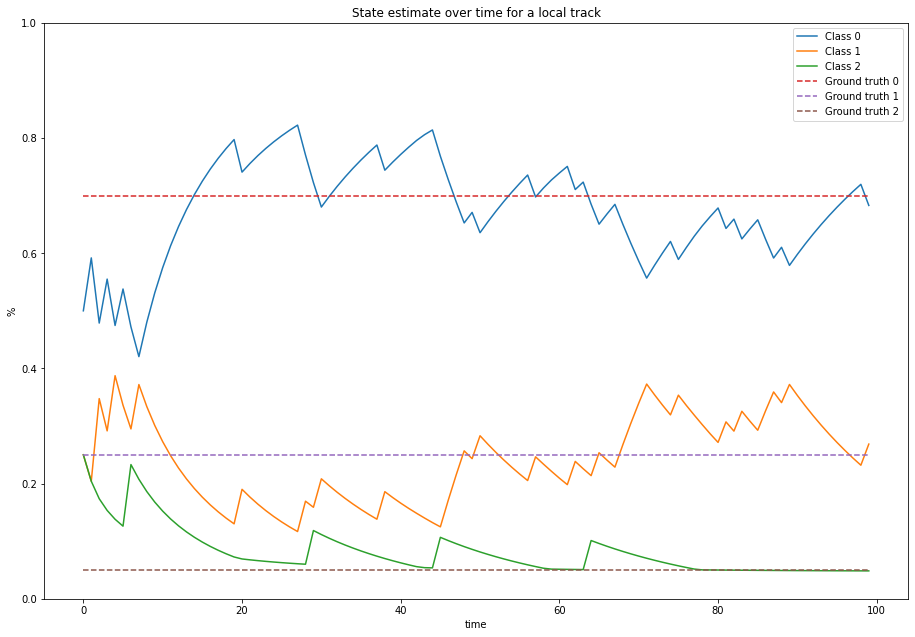

In [8]:
local_track = DirichletFilter()
generator = ClassifierSimulator()
states = []

for i in range(100):
    local_track.predict(local_track.measurement_period)
    measurement = generator.generate_measurement()
    local_track.update(measurement)
    states.append(local_track.state)


time = range(len(states))
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])
for i in range(num_classes):
    s = [x[i] for x in states]
    ax.plot(time, s, label="Class " + str(i))
ax.plot(
    time,
    [generator.probability] * len(time),
    linestyle="dashed",
    label="Ground truth 0",
)
ax.plot(
    time, [generator.neighbour] * len(time), linestyle="dashed", label="Ground truth 1"
)
ax.plot(
    time,
    [1 - (generator.probability + generator.neighbour)] * len(time),
    linestyle="dashed",
    label="Ground truth 2",
)
ax.set_ylim(0, 1)
ax.set_title("State estimate over time for a local track")
ax.set_xlabel("time")
ax.set_ylabel("%")
plt.legend()
plt.show()

As one can see, the Dirichlet distribution converges more or less against the correct probabilities, of each class provided by the generator.

## Prediction behaviour of the Dirichlet filter <a class="anchor" id="prediction-behaviour"></a>

To gain further intuition of the Dirichlet filter, lets have a look at the prediction behaviour.

In the example below after half the time, no more updates will be given to the Dirichlet Filter.

This shows how the underlying Dirichlet distribution converges against a uniform distribution.

In [9]:
track = DirichletFilter()
generator = ClassifierSimulator()
states = []
alphas = []
runs = 100
time = range(runs)
for i in time:
    track.predict(track.measurement_period)

    if i < (runs / 2.0):
        measurement = generator.generate_measurement()
        track.update(measurement)
    states.append(track.state)
    alphas.append(track.alpha)

## Plotting
fig, (ax, ax_dirichlet) = plt.subplots(1, 2, figsize=(12, 8))
line_plots = []
line_plots.append(ax.plot([], [])[0])
line_plots.append(ax.plot([], [])[0])
line_plots.append(ax.plot([], [])[0])
ax.set_ylim(0, 1)
ax.set_xlim(0, len(time))
ax.set_title("State estimate over time for a local track")
ax.set_xlabel("time")
ax.set_ylabel("%")
ax.axvline(runs // 2, color="red")

s = []
for i in range(num_classes):
    s.append([x[i] for x in states])


def animate(t):
    for i in range(num_classes):
        l = line_plots[i]
        l.set_data(time[:t], s[i][:t])
    dirichlet_distribution = Dirichlet(alphas[t])
    draw_pdf_contours(ax_dirichlet, dirichlet_distribution)


ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(time))
plt.close()
from IPython.display import HTML

HTML(ani.to_jshtml())

# Fusion of multiple Dirichlet filters  <a class="anchor" id="fusion"></a>

If one has multiple sensors and therefore multiple local estimations, we need to combine them in a global estimation (aka. Fusion).
This fusion can be modeled again with a Dirichlet filter to track the class information.
As we have seen in the [Update](#Update) section, the measurement is simply a vector containing counts of occured events.

In general, we can obtain the measurement in different ways from the local estimation:

- using an argmax of the state as a measurement similar to the local estimation: e.g. (0,1,0)
- using the state of the local estimations as measurement (aka. the current point estimate e.g. $\hat{\theta} = (0.2,0.7,0.1)$)
- using the alpha values of the local estimations as measurment: e.g. $\alpha=(3,10,1)$

Looking at this problem from an information perspective, the first option carries the least information. The second is better and the third carries all information of the local estimation as $\alpha$ is known to be a sufficient statistic of the Dirichlet distribution.

Nevertheless, it might be valueable to look at all of these approaches.

In order to keep the plots clear, lets first compare the two options on the top.



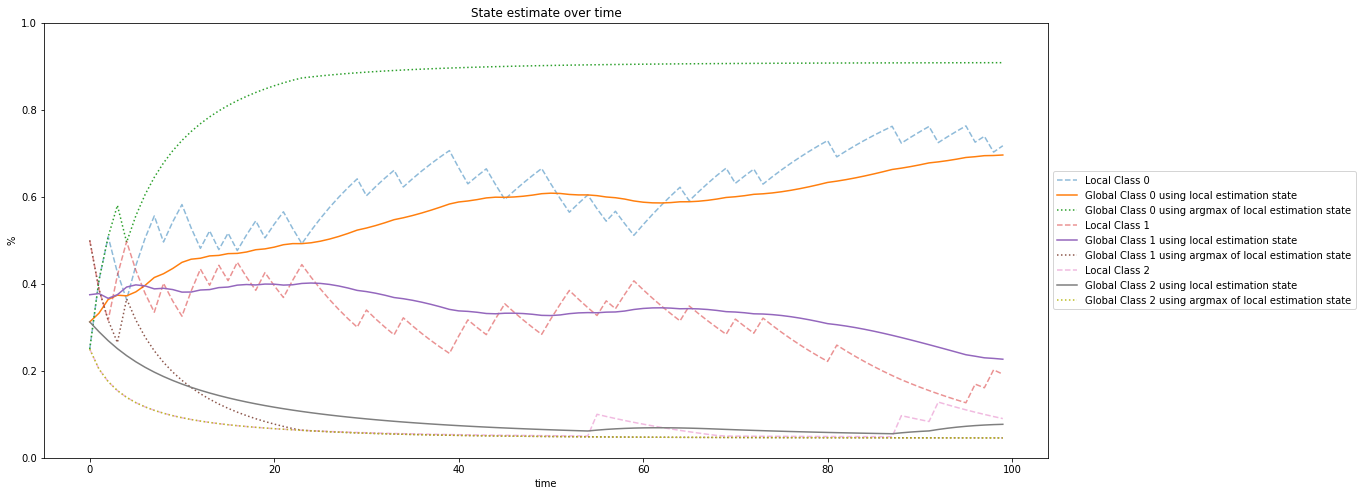

In [17]:
global_track_as_measurement = DirichletFilter()
global_track_with_state = DirichletFilter()
local_track = DirichletFilter()
states_local_track = []
states_global_track = []
states_global_track_measurement = []

for i in range(100):
    local_track.predict(local_track.measurement_period)
    measurement = generator.generate_measurement()
    local_track.update(measurement)
    states_local_track.append(local_track.state)

    global_track_with_state.predict(global_track_with_state.measurement_period)
    global_track_with_state.update(local_track.state)
    states_global_track.append(global_track_with_state.state)

    global_track_as_measurement.predict(global_track_as_measurement.measurement_period)
    measurement = np.zeros(num_classes)
    measurement_idx = np.argmax(local_track.state)
    measurement[measurement_idx] += 1
    global_track_as_measurement.update(measurement)
    states_global_track_measurement.append(global_track_as_measurement.state)

    
time = range(len(states))
fig, ax = plt.subplots(1, figsize=(18, 8))
for i in range(num_classes):
    s = [x[i] for x in states_local_track]
    ax.plot(time, s, linestyle="dashed", alpha=0.5, label="Local Class " + str(i))
    s = [x[i] for x in states_global_track]
    ax.plot(time, s, label="Global Class " + str(i) + " using local estimation state")
    s = [x[i] for x in states_global_track_measurement]
    ax.plot(
        time,
        s,
        linestyle="dotted",
        label="Global Class " + str(i) + " using argmax of local estimation state",
    )
ax.set_ylim(0, 1)
ax.set_title("State estimate over time")
ax.set_xlabel("time")
ax.set_ylabel("%")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

From what we see above in the plot, one might be tempted to say that it would be better to use again the argmax of the local tracks state.

Appart from the fast converges with that method, it looses all information about the other classes.
Hence we get a false sense of confidence.

Whereas the global track which is using the state of the local track is keeping track of all classes. If the local_track is unsure about its underlying ground truth class, this knowledge is transfered to the global filter as well. (Assuming that there is only one true ground truth.


Now when we compare the second and the third approach aka.
$
z = \hat{\theta} \text{ or }\\
z = \alpha
$


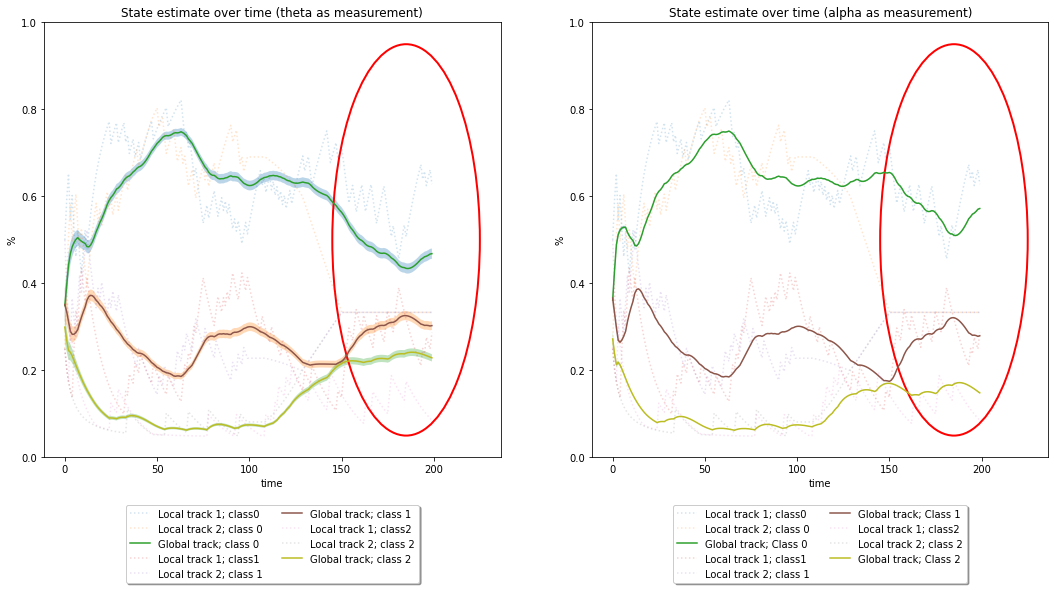

In [11]:
def calc_variance(self):
    a = self.alpha / np.sum(self.alpha)
    var = a * (1 - a) / (np.sum(self.alpha) + 1)
    return var


DirichletFilter.var = calc_variance
time_steps = 200

global_track_with_alpha = DirichletFilter()
global_track_with_state = DirichletFilter()
local_track1 = DirichletFilter()
local_track2 = DirichletFilter()
states_local_track1 = []
states_local_track2 = []
states_global_track_state = []
states_global_track_alpha = []
var_global_track_state = []
var_global_track_alpha = []

for i in range(time_steps):
    local_track1.predict(local_track1.measurement_period)
    measurement = generator.generate_measurement()
    local_track1.update(measurement)
    states_local_track1.append(local_track1.state)

    local_track2.predict(local_track2.measurement_period)
    if i < time_steps / 2.0:
        measurement = generator.generate_measurement()
        local_track2.update(measurement)
    states_local_track2.append(local_track2.state)

    global_track_with_state.predict(global_track_with_state.measurement_period)
    global_track_with_state.update(local_track1.state)
    global_track_with_state.predict(global_track_with_state.measurement_period)
    global_track_with_state.update(local_track2.state)
    states_global_track_state.append(global_track_with_state.state)
    var_global_track_state.append(global_track_with_state.var())

    global_track_with_alpha.predict(global_track_with_alpha.measurement_period)
    global_track_with_alpha.update(local_track1.alpha)
    global_track_with_alpha.predict(global_track_with_alpha.measurement_period)
    global_track_with_alpha.update(local_track2.alpha)
    states_global_track_alpha.append(global_track_with_alpha.state)
    var_global_track_alpha.append(global_track_with_alpha.var())


time = range(time_steps)
fig, (ax_state, ax_alpha) = plt.subplots(1, 2, figsize=(18, 8))
for i in range(num_classes):
    s = [x[i] for x in states_local_track1]
    ax_state.plot(
        time, s, linestyle="dotted", alpha=0.2, label="Local track 1; class" + str(i)
    )
    ax_alpha.plot(
        time, s, linestyle="dotted", alpha=0.2, label="Local track 1; class" + str(i)
    )
    s = [x[i] for x in states_local_track2]
    ax_state.plot(
        time, s, linestyle="dotted", alpha=0.2, label="Local track 2; class " + str(i)
    )
    ax_alpha.plot(
        time, s, linestyle="dotted", alpha=0.2, label="Local track 2; class " + str(i)
    )

    s = np.array([x[i] for x in states_global_track_state])
    v = np.array([x[i] for x in var_global_track_state])
    ax_state.plot(time, s, label="Global track; class " + str(i))
    ax_state.fill_between(time, s - v, s + v, alpha=0.3)

    s = [x[i] for x in states_global_track_alpha]
    v = np.array([x[i] for x in var_global_track_alpha])
    ax_alpha.plot(time, s, label="Global track; Class " + str(i))
    ax_alpha.fill_between(time, s - v, s + v, alpha=0.3)


for ax in (ax_alpha, ax_state):
    ax.set_ylim(0, 1)
    ax.set_xlabel("time")
    ax.set_ylabel("%")
    ax.legend(
        loc="lower center",
        bbox_to_anchor=(0.5, -0.3),
        fancybox=True,
        shadow=True,
        ncol=2,
    )

for ax, last_state in zip(
    (ax_state, ax_alpha), [states_global_track_state[-1], states_global_track_alpha[-1]]
):
    ellipse = Ellipse(
        xy=(185, 0.5), width=80, height=0.9, edgecolor="r", fc="None", lw=2
    )
    ax.add_patch(ellipse)

ax_alpha.set_title("State estimate over time (alpha as measurement)")
ax_state.set_title("State estimate over time (theta as measurement)")

plt.show()

One can see, that overall the variance is quite small. Nevertheless it is smaller when using $\alpha$ as the measurement. This is due to the fact that in this case we add more than one to the count variable within one update.

The major difference is at the end, where the filter dependent on the state does not incorporate the uncertainty of the track, which is not updated anymore, whereas the track using the $\alpha$ measurement ignores the local track which has no more information at the end. 

What can't be easily been seen is that the fusion with the $\alpha$ values as measurement does converge faster than the one with the state as measurement.

<div class="alert alert-block alert-info"><b>Decision fusion measurement:</b>

If possible use the $\alpha$ values as the measurement of the fusion.
</div>


# Merge of Dirichlet distributions <a class="anchor" id="merge"></a>

As it is common in tracking to merge two objects, if they are too similar, we also need to merge their class distributions.

As $\alpha$ is a sufficient statistic for the Dirichlet distribution, we can combine those parameters of both objects.

Two possible ways would be to either.

* use the average of the $\alpha$ values
* add the $\alpha$ values

In the plots below, one can see that the only difference between these approaches is the uncertainty in the merged distribution.

<div class="alert alert-block alert-info"><b>Decision merging:</b>

As we have a limited the total value of $\alpha$, we would introduce a false sense of certainty, if we only add the $\alpha$ parameters for the merge.
Taking the average limits the certainty to the same level as all other objects.

Hence the **average merge** should be used. 
</div>


In [12]:
lines = "class DirichletFilter\n"
lines += "    ...\n\n"
lines += inspect.getsource(DirichletFilter.merge)
lines += "\n"
lines += inspect.getsource(DirichletFilter.merge_average)
lines += "\n"
lines += inspect.getsource(DirichletFilter.merge_addition)
Code(lines, language="python")

class DirichletFilter
    ...

    def merge(self, other):
        return self.merge_average(other)

    def merge_average(self, other):
        merged_dirichlet = DirichletFilter()
        merged_dirichlet.alpha = (self.alpha + other.alpha) / 2.0
        merged_dirichlet.estimate_state()
        return merged_dirichlet

    def merge_addition(self, other):
        merged_dirichlet = DirichletFilter()
        merged_dirichlet.alpha = (self.alpha + other.alpha) / 2.0
        merged_dirichlet.estimate_state()
        return merged_dirichlet

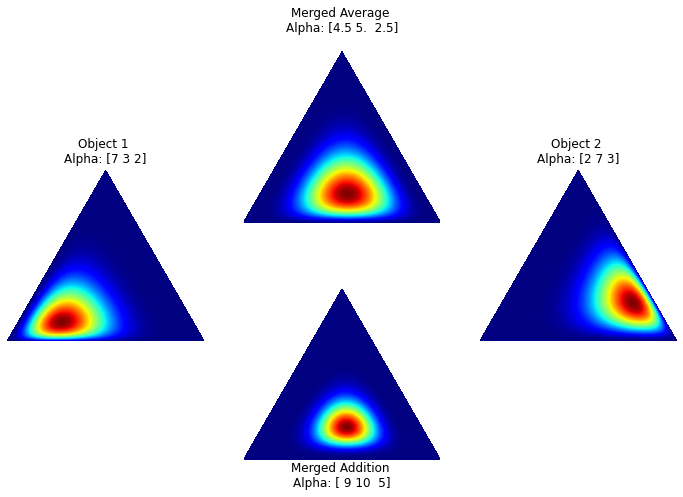

In [13]:

alpha_1 = np.array([7, 3, 2])
alpha_2 = np.array([2, 7, 3])

merged_average_alpha = (alpha_1 + alpha_2) / 2.0
merged_added_alpha = alpha_1 + alpha_2


fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

ax_1 = plt.subplot(gs[0:2, 0])
ax_2 = plt.subplot(gs[0:2, 2])
ax_merged_avg = plt.subplot(gs[0:1, 1])
ax_merged_add = plt.subplot(gs[1:2, 1])


draw_pdf_contours(ax_1, Dirichlet(alpha_1))
draw_pdf_contours(ax_2, Dirichlet(alpha_2))
draw_pdf_contours(ax_merged_avg, Dirichlet(merged_average_alpha))
draw_pdf_contours(ax_merged_add, Dirichlet(merged_added_alpha))

ax_1.set_title("Object 1 \n" + ax_1.title.get_text(), y=0.7)
ax_2.set_title("Object 2 \n" + ax_2.title.get_text(), y=0.7)
ax_merged_avg.set_title("Merged Average \n" + ax_merged_avg.title.get_text())
ax_merged_add.set_title("Merged Addition \n" + ax_merged_add.title.get_text(), y=-0.1)
plt.show()

# Use Uncertainty of Dirichlet Distribution <a class="anchor" id="uncertainty"></a>


Up until now we estimate the distribution of the measured classes on our object.

We could simply omit the uncertainty of the current estimate and use it the probability of our object belonging to the a certain class. But we can do better.

Without the uncertainty information, which is provided by the Dirichlet distribution, we might output high probabilities of an object belonging to a certain class, but we aren't sure about it in any way.

In order to fix this, we can multiply the current state estimate with the likelihood of named state estimate.
From now on this is called the weight.

As the likelihood is calculated for the complete state, it is only a scaling. Meaning it does not effect the order!

This scaling can be seen in two scenarios:
* Directly after the birth of the object, the weight represents correctly our weak belief about the class
* Once an object does not receive any updates, the confidence drops directly, instead of the "dead time"


As calculating the pdf of a Dirichlet distribution is quite costly, we can use the log-likelihood to reduce the computation needed.


Dirichlet Log-Likelihood:

>$
 \log(Dir(\theta|\alpha)) = \log(\Gamma(\sum_{i=1}^{K} \alpha_i)) + \sum_{i=1}^K (\alpha_i-1)\log(\theta_i) - \sum_{i=1}^K \log(\Gamma(\alpha_i))
$

<div class="alert alert-block alert-info"><b>Decision output:</b>

We use the product of the log-likelihood of the Dirichlet distribution and the the current state estimate as output variable.
    
$w = \theta*\log(Dir(\theta|\alpha))$
</div>


In [14]:
lines = "class DirichletFilter\n"
lines += "    ...\n\n"
lines += inspect.getsource(DirichletFilter.log_likelihood)
lines += "\n"
lines += inspect.getsource(DirichletFilter.calc_weights)
Code(lines, language="python")

class DirichletFilter
    ...

    def log_likelihood(self):
        return (
                math.lgamma(np.sum(self.alpha))
                + np.sum((self.alpha - 1) * (np.log(self.state)))
                - np.sum(np.array([math.lgamma(i) for i in self.alpha]))
        )

    def calc_weights(self):
        return self.state * self.log_likelihood()

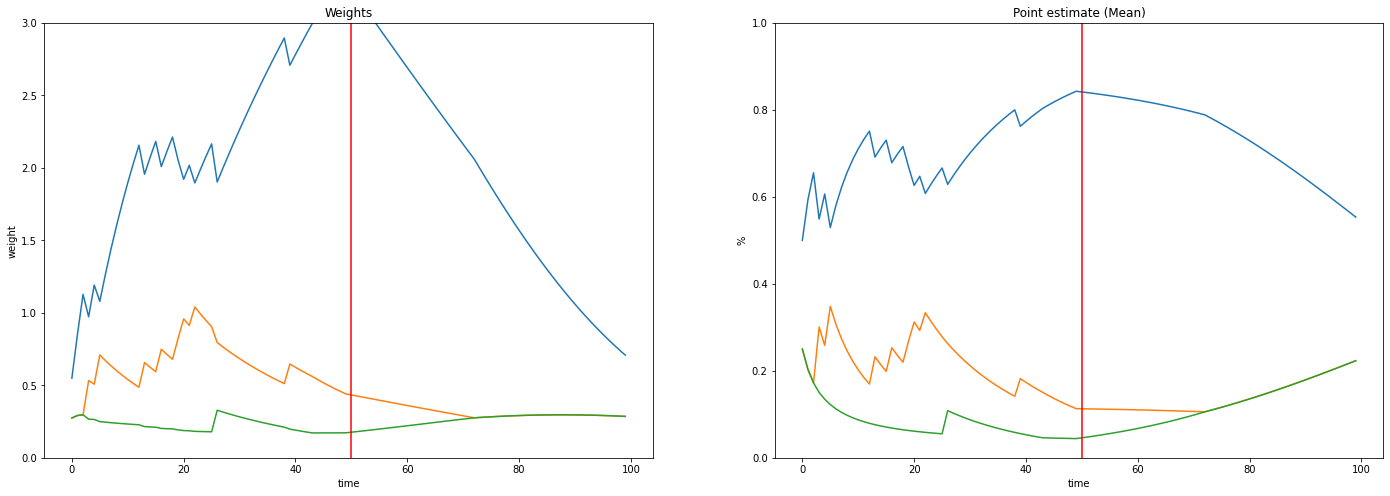

In [15]:
filter = DirichletFilter()
filter.decay_factor = 0.96
weights = []
states = []

gen = ClassifierSimulator()


num_steps = 100

for i in range(num_steps):
    filter.predict(filter.measurement_period)
    measurement = gen.generate_measurement()

    if i < num_steps // 2:
        filter.update(measurement)

    weights.append(filter.calc_weights())
    states.append(filter.state)


fig, (ax_weight, ax_prop) = plt.subplots(1, 2, figsize=(24, 8))
steps = range(len(weights))

ax_weight.plot(steps, weights)
ax_weight.set_title("Weights")
ax_weight.set_ylabel("weight")
ax_weight.set_ylim(0, 3)
ax_prop.plot(steps, states)
ax_prop.set_title("Point estimate (Mean)")
ax_prop.set_ylabel("%")
ax_prop.set_ylim(0, 1)

for ax in (ax_weight, ax_prop):
    ax.set_xlabel("time")
    ax.axvline(num_steps // 2, color="red")

plt.show()

# Normalize Weights based on max likelihood <a class="anchor" id="normalization"></a>

As the prediction defines the max likelihood, it is also possible to normalize the output of the weight.

But for now, there is no reason on why you need this.

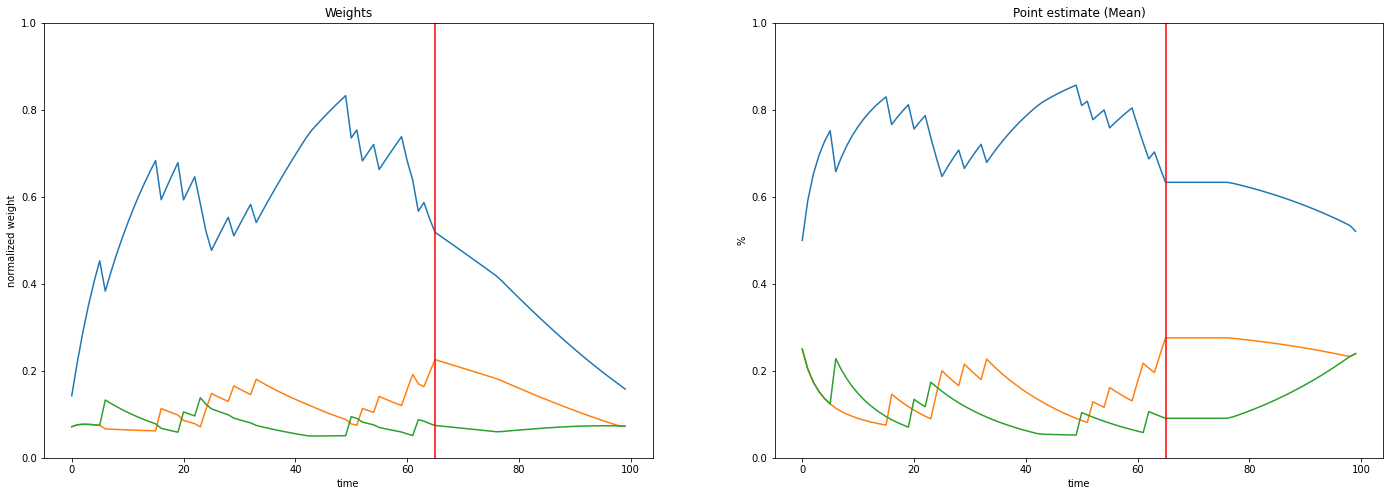

In [16]:
def max_log_likelihood(self, maxMeasurement=1):
    max_alpha = maxMeasurement/(1-self.decay_factor)
    
    filter = DirichletFilter()
    filter.decay_factor = self.decay_factor
    filter.alpha = np.array([max_alpha,1,1])
    filter.estimate_state()   
    
    return filter.log_likelihood() * np.max(filter.state)


DirichletFilter.max_log_likelihood = max_log_likelihood

filter = DirichletFilter()
filter.decay_factor = 0.95
weights = []
states = []

gen = ClassifierSimulator()

max_log_likelihood = filter.max_log_likelihood()
num_steps = 100
no_updates_timestep = num_steps*2 // 3

for i in range(num_steps):
    filter.predict(filter.measurement_period)
    measurement = gen.generate_measurement()

    if i <no_updates_timestep:
        filter.update(measurement)

    weights.append(filter.calc_weights()/max_log_likelihood)
    states.append(filter.state)


fig, (ax_weight, ax_prop) = plt.subplots(1, 2, figsize=(24, 8))
steps = range(len(weights))

ax_weight.plot(steps, weights)
ax_weight.set_title("Weights")
ax_weight.set_ylabel("normalized weight")
ax_prop.plot(steps, states)
ax_prop.set_title("Point estimate (Mean)")
ax_prop.set_ylabel("%")

for ax in (ax_weight, ax_prop):
    ax.set_xlabel("time")
    ax.set_ylim(0, 1)
    ax.axvline(no_updates_timestep-1, color="red")

plt.show()